In [ ]:
!nvidia-smi #connect to GPU Backend

Fri Apr  9 11:06:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
try:
    shutil.rmtree("inaturalist_12K")
except:
    pass

try:
    os.remove("nature_12K.zip")
except:
    pass

In [ ]:
!gdown https://drive.google.com/uc?id=1AWK5fe-W29Bry_GytbDMqoFwQXVom56s

Downloading...
From: https://drive.google.com/uc?id=1AWK5fe-W29Bry_GytbDMqoFwQXVom56s
To: /content/nature_12K.zip
3.82GB [01:04, 59.3MB/s]


In [ ]:
%%capture
!unzip "/content/nature_12K.zip"

In [ ]:
%%capture
! pip install wandb

In [ ]:
!find . -name "*.DS_Store" -type f -delete

# Importing Libraries

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D , MaxPool2D , Flatten , Dropout, Dense, Activation, BatchNormalization
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential, load_model
import random
import wandb
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback

# Exploring the Data

In [ ]:
# list of class names
temp = os.listdir("inaturalist_12K/train")
class_names = [name for name in temp if name != ".DS_Store"]
print("The names of the classes are:")
print(class_names)

num_classes = len(class_names)
print(f"Number of classes = {num_classes}\n")

M = 0
M_test = 0

for each_class in class_names:
    train_images = os.listdir("inaturalist_12K/train/"+each_class)
    test_images = os.listdir("inaturalist_12K/val/"+each_class)
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images))
    filtered_test_images = list(filter(lambda x: x!=".DS_Store", test_images))
    M = M + len(filtered_train_images)
    M_test = M_test + len(filtered_test_images)

print(f"Total number of training images = {M}")
print(f"Total number of test images = {M_test}\n")

The names of the classes are:
['Fungi', 'Mammalia', 'Aves', 'Mollusca', 'Animalia', 'Reptilia', 'Arachnida', 'Insecta', 'Amphibia', 'Plantae']
Number of classes = 10

Total number of training images = 9000
Total number of test images = 2000



Since the image sizes of the naturalist data set are varied and we are constrained by computational resources, we shall resize all the images to (224,224) rgb







In [ ]:
input_image_shape = (224, 224, 3)

Create Validation Set

In [ ]:
validation_split_fraction = 0.1

try:
    shutil.rmtree("inaturalist_12K/validation/")
except:
    pass
    
os.mkdir("inaturalist_12K/validation/")

for each_class in class_names:
    os.mkdir("inaturalist_12K/validation/"+each_class)
    train_images = os.listdir("inaturalist_12K/train/"+each_class)
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images))
    count = len(filtered_train_images)
    random.shuffle(filtered_train_images) # Shuffle the training images

    validation_images = filtered_train_images[:round(validation_split_fraction*count)]

    for im in validation_images:
        shutil.move("inaturalist_12K/train/"+each_class+"/"+im, "inaturalist_12K/validation/"+each_class+"/"+im)

### Setting up Train Test and Validation generators

In [ ]:
def make_generators(train_batch_size, data_aug):
    '''make train,test and validation image generators based on image augmentation flag
  
    Parameters:
    -----------
    train_batch_size: int

    data_aug: bool
      True if data augmentation is intended

    Returns:
    --------
    train_generator,validation_generator and test_generator

    '''

    if data_aug:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        horizontal_flip=True,
                                        zoom_range=0.2,
                                        fill_mode="nearest")
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    val_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'inaturalist_12K/train',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    # batch_size for validation and test generator should perfectly divide the total number of examples
    validation_generator = val_datagen.flow_from_directory(
        'inaturalist_12K/validation',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    test_generator = test_datagen.flow_from_directory(
        'inaturalist_12K/val',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode='categorical',
        shuffle=False,
        seed=42)
    
    return train_generator, validation_generator, test_generator

In [ ]:
import tensorflow.keras as K


### Build the model

In [ ]:
def define_model(pretrained_model_name, activation_function_dense, fc_layer, dropout, pre_layer_train=None):
    '''
    define a keras sequential model based on a pre-trained model intended to be fine tuned
    '''

    input_ = K.Input(shape = input_image_shape)

    # add a pretrained model without the top dense layer
    if pretrained_model_name == 'ResNet50':
      pretrained_model = K.applications.ResNet50(include_top = False, weights='imagenet',input_tensor = input_)
    elif pretrained_model_name == 'InceptionV3':
      pretrained_model = K.applications.InceptionV3(include_top = False, weights='imagenet',input_tensor = input_)
    elif pretrained_model_name == 'InceptionResNetV2':
      pretrained_model = K.applications.InceptionResNetV2(include_top = False, weights='imagenet',input_tensor = input_)
    else:
      pretrained_model = K.applications.Xception(include_top = False, weights='imagenet',input_tensor = input_)
    
    #freeze all layers
    for layer in pretrained_model.layers:
        layer.trainable=False 
    
    #set some of the top layers as trainable
    if pre_layer_train:
      for layer in pretrained_model.layers[-pre_layer_train:]:
        layer.trainable=True

    model = K.models.Sequential()
    model.add(pretrained_model)#add pretrained model
    model.add(Flatten()) # The flatten layer is essential to convert the feature map into a column vector
    model.add(Dense(fc_layer, activation=activation_function_dense))#add a dense layer
    model.add(Dropout(dropout)) # For dropout
    model.add(Dense(10, activation="softmax"))#softmax layer

    return model

In [ ]:
def train_validate_model(train_batch_size, pre_train_model, data_aug, activation_function_dense, fc_layer, dropout, pre_layer_train=None):
  '''
  train the model based on the given hyperparameters and plot the train and validation metrics at every epoch
  '''
  # Create the data generators
  train_generator, validation_generator, test_generator = make_generators(train_batch_size, data_aug)
    
  # Define the model
  model = define_model(pretrained_model_name=pre_train_model, activation_function_dense=activation_function_dense, fc_layer=fc_layer, dropout=dropout, pre_layer_train=pre_layer_train)
  print(model.summary())

  TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
  VALIDATION_STEP_SIZE = validation_generator.n//validation_generator.batch_size

  #compile
  model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

  # Early Stopping callback
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

  # To save the model with best validation accuracy
  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

  history = model.fit(train_generator,
                      steps_per_epoch = TRAIN_STEP_SIZE,
                      validation_data = validation_generator,
                      validation_steps = VALIDATION_STEP_SIZE,
                      epochs=5, 
                      callbacks=[earlyStopping, mc],
                      verbose=2)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  return history

### Best model

In [ ]:
def train_validate_test_model(train_batch_size, pre_train_model, data_aug, activation_function_dense, fc_layer, dropout, epochs, pre_layer_train=None):
  '''
  train the model based on the given hyperparameters and plot the train and validation metrics at every epoch.
  print the test accuracy
  '''
  # Create the data generators
  train_generator, validation_generator, test_generator = make_generators(train_batch_size, data_aug)
    
  # Define the model
  model = define_model(pretrained_model_name=pre_train_model, activation_function_dense=activation_function_dense, fc_layer=fc_layer, dropout=dropout, pre_layer_train=pre_layer_train)
  print(model.summary())

  TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
  VALIDATION_STEP_SIZE = validation_generator.n//validation_generator.batch_size
  TEST_STEP_SIZE = test_generator.n//test_generator.batch_size

  model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

  # Early Stopping callback
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

  # To save the model with best validation accuracy
  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

  history = model.fit(train_generator,
                      steps_per_epoch = TRAIN_STEP_SIZE,
                      validation_data = validation_generator,
                      validation_steps = VALIDATION_STEP_SIZE,
                      epochs=epochs, 
                      callbacks=[earlyStopping, mc],
                      verbose=2)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  print("Test accuracy = " + str(model.evaluate_generator(test_generator,TEST_STEP_SIZE)[1])+"%")

  return history

### The best model according to wandb sweeps is given below

Found 8100 images belonging to 10 classes.
Found 900 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_4 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               19661312  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 74,003,178
Trainable params: 24,897,418
Non-trainable params: 49,105,760
_____________________________________

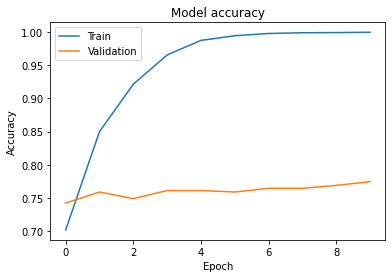

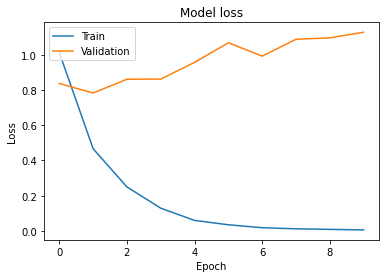

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test accuracy = 0.7975000143051147%


In [ ]:
train_validate_test_model(train_batch_size=128, pre_train_model='InceptionResNetV2', data_aug=False, activation_function_dense='relu', fc_layer=512, dropout=0.2, epochs= 10, pre_layer_train=20)